In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
import sklearn
import distance
import warnings
from nltk.corpus import stopwords
import distance
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv("questions.csv")
df.shape

(404351, 6)

In [11]:
df.drop_duplicates(inplace=True)
df.shape

(404351, 6)

In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [13]:
df.dropna(inplace=True)
df.shape

(404348, 6)

In [14]:
new_df=df.sample(30000,random_state=2)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 302477 to 174229
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.6+ MB


[Text(0, 0, 'Not_Duplicate = 0'), Text(1, 0, 'Duplicate = 1')]

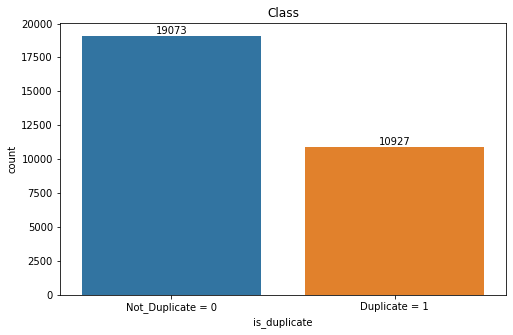

In [15]:
ax , fig = plt.subplots(figsize = [8,5])  
ax = sns.countplot(data = new_df , x = 'is_duplicate') 
plt.title('Class');
ax.bar_label(ax.containers[0])  # bar contains object of 2 artist 
ax.set_xticklabels(['Not_Duplicate = 0', 'Duplicate = 1'])

<AxesSubplot:ylabel='is_duplicate'>

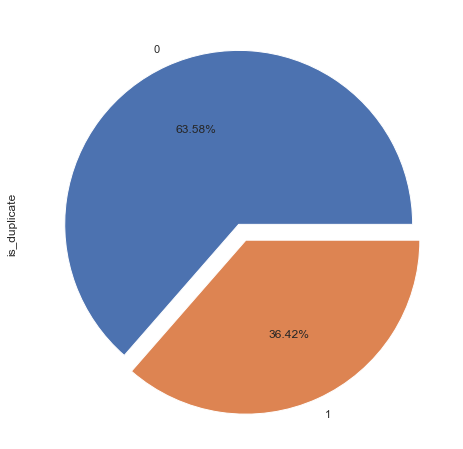

In [16]:
sns.set(rc={'figure.figsize':(12,8)}) 
new_df.is_duplicate.value_counts().plot(kind='pie',autopct='%.2f%%',explode=(0,0.1))

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


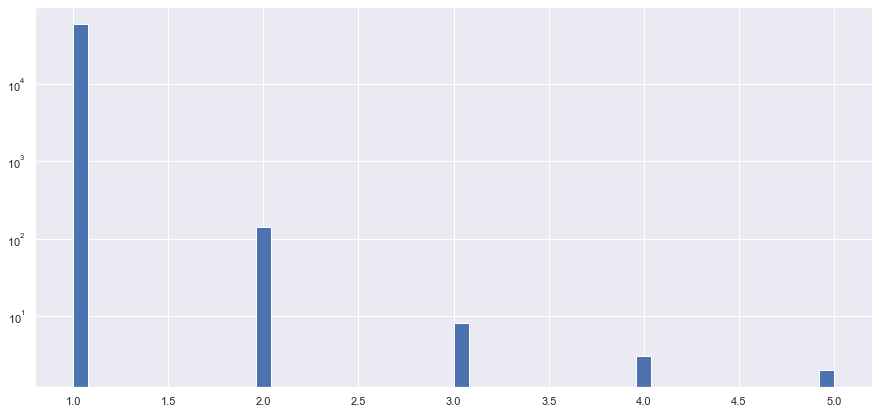

In [17]:
qid=pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
plt.figure(figsize=(15,7))
plt.hist(qid.value_counts().values,bins=50)
plt.yscale('log')
plt.show()

In [18]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    
    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    # Remove URL
    pattern = re.compile(r'https?://\S+|www\.\S+')
    q = pattern.sub(r'',q)
    
    return q

In [19]:
new_df['question1']=new_df['question1'].apply(preprocess)
new_df['question2']=new_df['question2'].apply(preprocess)

In [20]:
ps = PorterStemmer()
def stem_words(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [21]:
new_df['question1']=new_df['question1'].apply(stem_words)
new_df['question2']=new_df['question2'].apply(stem_words)

In [22]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1


In [23]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

In [24]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0,30,39,6,9
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0,24,45,4,9
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0,93,93,24,24
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1,43,56,8,10
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1,61,68,12,14


In [25]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [26]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0,30,39,6,9,4
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0,24,45,4,9,0
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0,93,93,24,24,18
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1,43,56,8,10,6
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1,61,68,12,14,8


In [27]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [28]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0,30,39,6,9,4,15
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0,24,45,4,9,0,13
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0,93,93,24,24,18,36
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1,43,56,8,10,6,18
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1,61,68,12,14,8,26


In [29]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0,30,39,6,9,4,15,0.27
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0,24,45,4,9,0,13,0.00
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0,93,93,24,24,18,36,0.50
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1,43,56,8,10,6,18,0.33
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1,61,68,12,14,8,26,0.31


In [30]:
# Advanced Features
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [31]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [32]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0,30,39,6,9,...,15,0.27,0.666644,0.499988,0.666644,0.399992,0.666656,0.444440,0.0,1.0
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0,24,45,4,9,...,13,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0,93,93,24,24,...,36,0.50,0.999992,0.999992,0.999980,0.999980,0.749997,0.749997,1.0,1.0
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1,43,56,8,10,...,18,0.33,0.799984,0.571420,0.666644,0.666644,0.749991,0.599994,0.0,1.0
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1,61,68,12,14,...,26,0.31,0.666659,0.599994,0.666644,0.499988,0.666661,0.571424,0.0,0.0


In [33]:
def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [34]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [35]:
print(new_df.shape)
new_df.head()

(30000, 24)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
302477,302477,594007,594008,what are kalman filter use for,what are exampl of filter use in a home,0,30,39,6,9,...,0.499988,0.666644,0.399992,0.666656,0.444440,0.0,1.0,3.0,7.5,0.387097
369857,369857,723787,723788,how do relationship work,what matter in the life most digniti or money,0,24,45,4,9,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.0,6.5,0.080000
4665,4665,9325,9326,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...,0,93,93,24,24,...,0.999992,0.999980,0.999980,0.749997,0.749997,1.0,1.0,0.0,24.0,0.989362
54203,54203,107861,107862,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...,1,43,56,8,10,...,0.571420,0.666644,0.666644,0.749991,0.599994,0.0,1.0,2.0,9.0,0.363636
132567,132567,262555,262556,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...,1,61,68,12,14,...,0.599994,0.666644,0.499988,0.666661,0.571424,0.0,0.0,2.0,13.0,0.241935


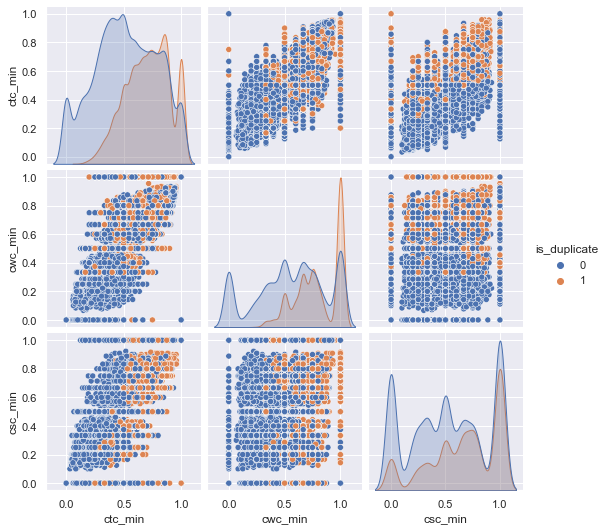

In [36]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

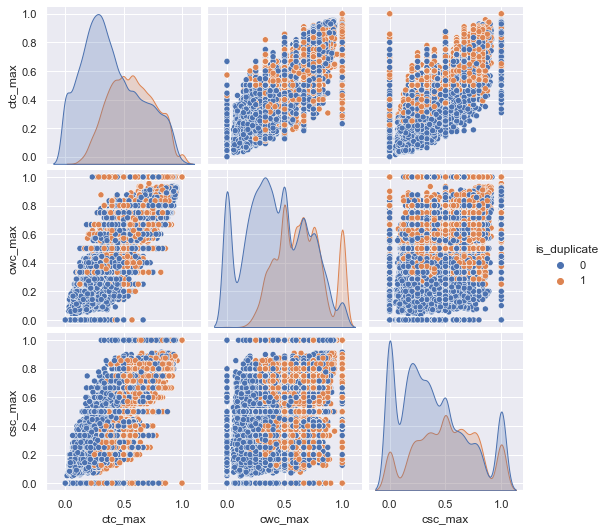

In [37]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

In [38]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
302477,what are kalman filter use for,what are exampl of filter use in a home
369857,how do relationship work,what matter in the life most digniti or money
4665,how would an arbitrageur seek to capit given t...,how would an arbitrageur seek to capit given t...
54203,whi did quora mark my question as incomplet,whi doe quora detect my question as an incompl...
132567,doe googl map account for chang in speed when ...,what speed doe googl map assum when it gener e...


In [39]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 19)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
302477,0,30,39,6,9,4,15,0.27,0.666644,0.499988,0.666644,0.399992,0.666656,0.444440,0.0,1.0,3.0,7.5,0.387097
369857,0,24,45,4,9,0,13,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,5.0,6.5,0.080000
4665,0,93,93,24,24,18,36,0.50,0.999992,0.999992,0.999980,0.999980,0.749997,0.749997,1.0,1.0,0.0,24.0,0.989362
54203,1,43,56,8,10,6,18,0.33,0.799984,0.571420,0.666644,0.666644,0.749991,0.599994,0.0,1.0,2.0,9.0,0.363636
132567,1,61,68,12,14,8,26,0.31,0.666659,0.599994,0.666644,0.499988,0.666661,0.571424,0.0,0.0,2.0,13.0,0.241935


In [40]:
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [41]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [42]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6019)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
302477,0,30,39,6,9,4,15,0.27,0.666644,0.499988,...,0,0,0,0,0,0,0,0,0,0
369857,0,24,45,4,9,0,13,0.00,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4665,0,93,93,24,24,18,36,0.50,0.999992,0.999992,...,0,0,0,0,0,0,0,0,0,0
54203,1,43,56,8,10,6,18,0.33,0.799984,0.571420,...,0,0,0,0,0,0,0,0,0,0
132567,1,61,68,12,14,8,26,0.31,0.666659,0.599994,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [50]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7753333333333333

In [57]:
# for xgboost model
recall=recall_score(y_test,y_pred1)
precision = precision_score(y_test,y_pred1)
print(f"the precision and recall score of random forest is {precision} and {recall}")

the precision and recall score of random forest is 0.6982456140350877 and 0.6512388966806919


In [58]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[3259,  602],
       [ 746, 1393]], dtype=int64)

In [59]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [60]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [61]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [62]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [63]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    q1=stem_words(q1)
    q2=stem_words(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    return np.hstack((np.array(input_query).reshape(1,18),q1_bow,q2_bow))

In [72]:
q1 = 'Where is the capital of India?'
q2 = 'What is capital of India?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [73]:
query_point_creator(q1,q4)

array([[27., 31.,  6., ...,  0.,  0.,  0.]])

In [74]:
xgb.predict(query_point_creator(q1,q2))

array([1])

In [75]:
cv 

CountVectorizer(max_features=3000)

In [76]:
import pickle

pickle.dump(xgb,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))
pickle.dump(ps,open('ps.pkl','wb'))